In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import proplot as pplt
from intakedata import Naming
import devices
import itertools
import pandas as pd
import matplotlib.patches as mpatches
from statsmodels.graphics.boxplots import violinplot


In [3]:
layer_fp = "/Users/jmccarty/GitHub/parametric-bipv-app/static/data/device_layer_data.json"
impact_fp = "/Users/jmccarty/GitHub/parametric-bipv-app/static/data/device_impact_data.json"
with open(layer_fp, "r") as fp:
    layer_data = json.load(fp)
    
with open(impact_fp, "r") as fp:
    impact_data = json.load(fp)

In [42]:
plot_dict = {}

for impact_category in Naming().raw_indicators:

    plot_data = {}
    for device_type in layer_data.keys():
        device_impacts = {}
        for list_item in layer_data[device_type]:
            layer = list_item['title']
            # combinations are made up of the unique possible layer_option and location_option combinations
            device_impacts[layer] = {}
            layer_options = list_item['options'].keys()
            for layer_option in layer_options:
                
                location_options = list_item['options'][layer_option]
                for location_option in location_options:
                    option_key = "-".join([layer_option, location_option, impact_category])
                    device_impacts[layer][option_key] = impact_data[device_type][layer][layer_option][location_option][impact_category]

        # Extract all combinations of layer options
        layer_combinations = list(itertools.product(*[options.values() for options in device_impacts.values()]))

        # Calculate the sum of climate change impacts for each combination
        device_plot = [sum(combination) for combination in layer_combinations]
        plot_data[device_type] = device_plot

    plot_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in plot_data.items() ]))
    
    plot_dict[impact_category] = plot_df

In [40]:
impact_cats = ["energy resources: non-renewable, fossil",
"acidification: terrestrial",
"climate change",
"ecotoxicity: freshwater",
"eutrophication: freshwater",
"eutrophication: marine",
"human toxicity: carcinogenic",
"human toxicity: non-carcinogenic",
"ionising radiation",
"land use",
"ozone depletion",
"particulate matter formation",
"photochemical oxidant formation: human health",
"photochemical oxidant formation: terrestrial ecosystems"]

In [14]:
lengths = {}

len_df = plot_dict['climate change']
for col in len_df.columns:
    s = len_df[col]
    print(col, len(s[~pd.isna(s)]))
    lengths[col] = len(s[~pd.isna(s)])

organic 28512
perovskite 228096
monocrystalline 186624
polycrystalline 124416
cdte 186624
cigs 279936


In [121]:
my_sys = devices.System("organic", loss_factor=0.25)
my_sys.reset_coverage(1)
# my_sys.n_devices = 1
my_sys.system_lifetime_output(1000,25)


1300.8375

In [12]:
power_annual_lib = {}
power_density_lib = {}

for device_name in ['organic', 'perovskite', 'monocrystalline', 'polycrystalline', 'cdte', 'cigs']:
    my_sys = devices.System(device_name, loss_factor=0.25)
    # my_sys.n_devices = 1
    my_sys.reset_coverage(1)
    lifetime_kwh = my_sys.system_lifetime_output(1000.,25)
    power_annual_lib[device_name] = lifetime_kwh
    power_density_lib[device_name] = my_sys.coverage / lifetime_kwh

def convert_data(data, power_density):
    return data * power_density

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

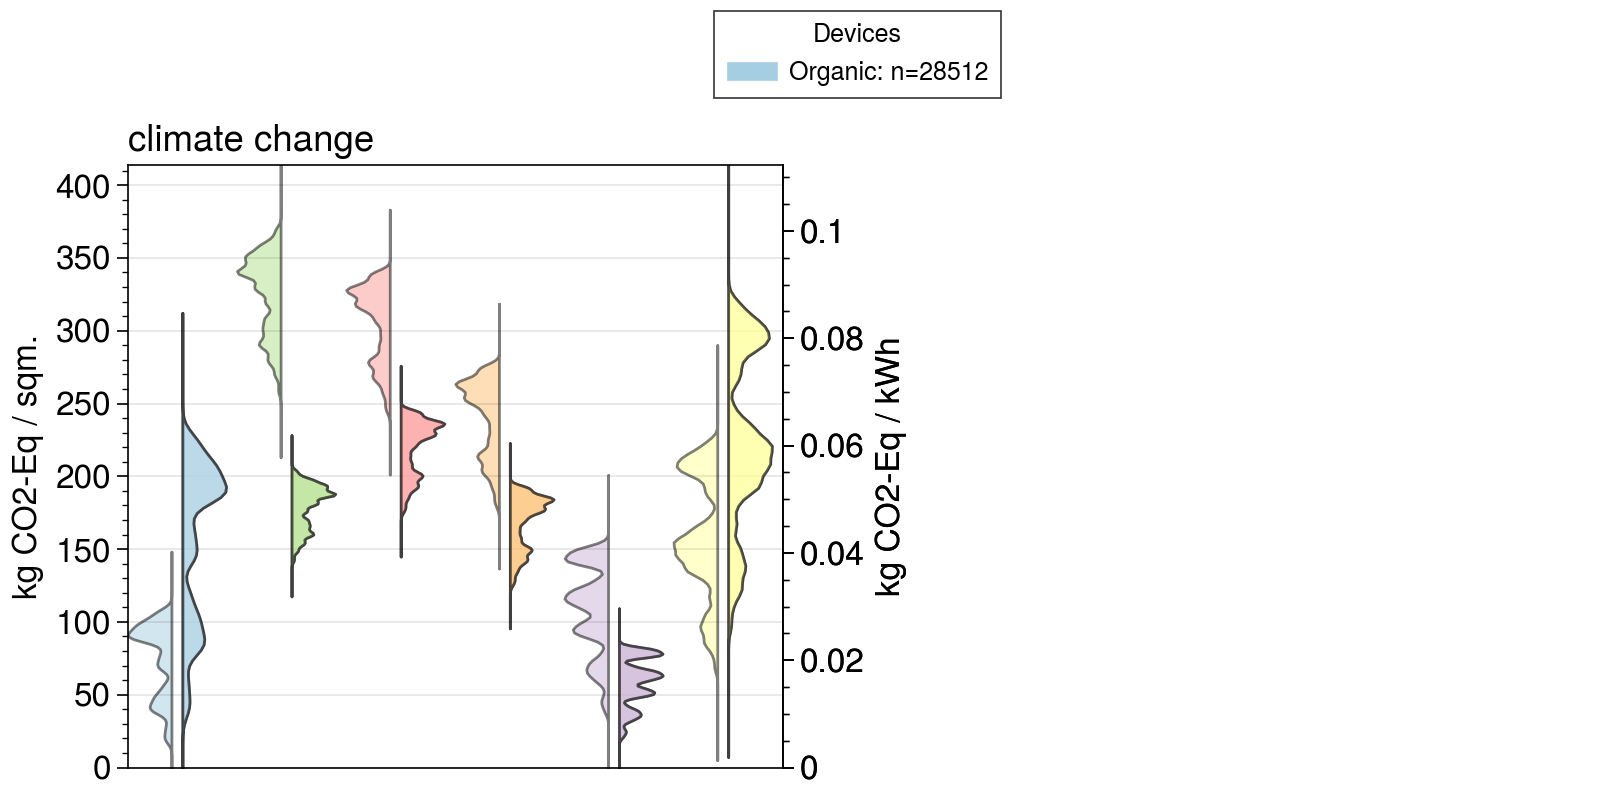

In [38]:
x_names = []
data_A_set = []
data_B_set = []
impact_cat = "climate change"
for col in plot_dict[impact_cat].columns:
    x_names.append(col)
    data_all = plot_dict[impact_cat][col].dropna().values 
    data_A_set.append(data_all)
    data_B = convert_data(data_all, power_density_lib[col])
    data_B_set.append(data_B)

square_size = 4
colors = pplt.get_colors("Paired")[::2]

impact_cat = 'climate change'
fig, axe = pplt.subplots(share=False, ncols=2, nrows=1, figsize=(square_size*2,square_size), facecolor='white')
ax = axe[0]
ax2 = ax.twinx()
adjust = 0.05
violinplot(data_A_set, positions=[a-adjust for a in [0,1,2,3,4,5]], show_boxplot=False, side='left', ax=ax, plot_opts={'violin_fc':'C0'})
violinplot(data_B_set, positions=[a+adjust for a in [0,1,2,3,4,5]], show_boxplot=False, side='right', ax=ax2, plot_opts={'violin_fc':'C1'})

for n in [0,1,2,3,4,5]:
        ax.get_children()[n].set_facecolor(colors[n])
        ax2.get_children()[n].set_facecolor(colors[n])

ax.format(ltitle=Naming().impact_categories_short[impact_cat],
        ylabel=Naming().impact_categories_units[impact_cat],
        ymin=0, fontsize=12)
ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks([])

ax2.format(ylabel=Naming().impact_categories_units[impact_cat].replace(" / sqm.", " / kWh"),
        ymin=0, fontsize=12)

lenged_ax = axe[-1] 
lenged_ax.set_axis_off()  # removes the XY axes
patches = [mpatches.Patch(color=c, linewidth=0.25,
                          label=f"{plot_dict[impact_cat].columns[n].capitalize()}: n={lengths[plot_dict[impact_cat].columns[n]]}") 
           for n,c in enumerate(colors[0:1])]
fig.legend(handles=patches, loc='top',
                 ncols=1, title='Devices', 
                 fontsize='200'
                 )



/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

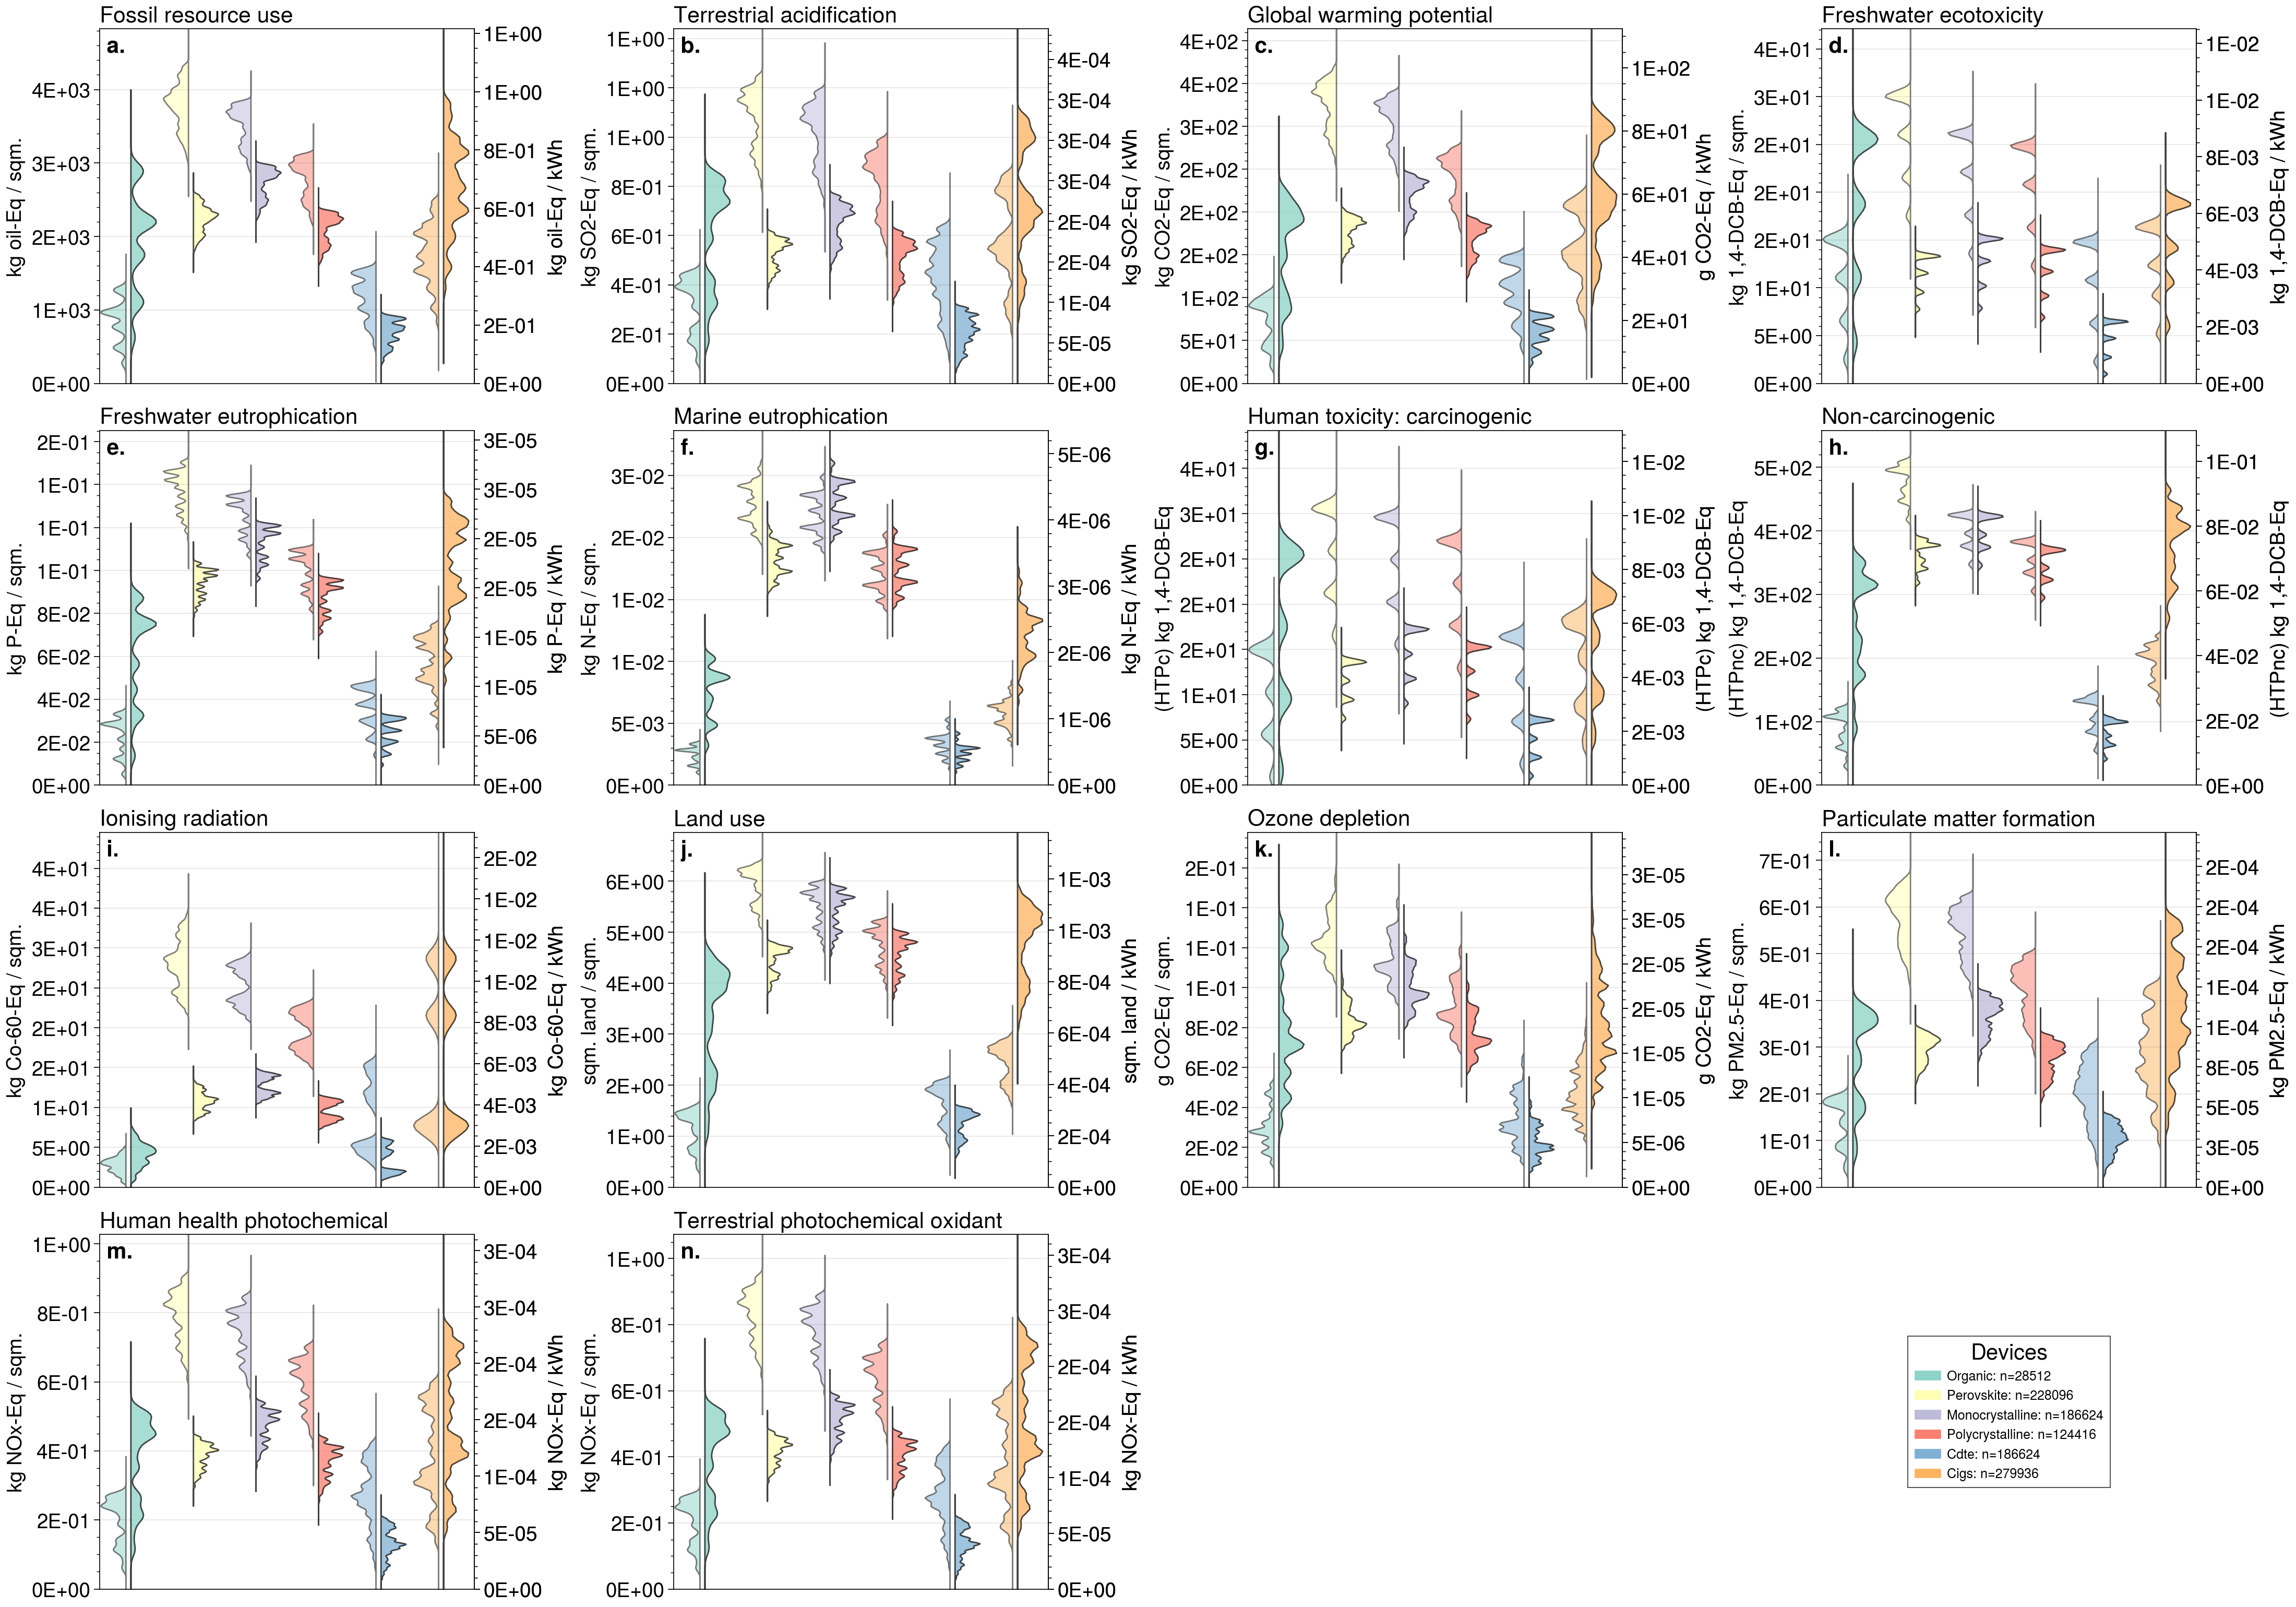

In [44]:
fs = 14
yformat = "%.E"
pplt.rc['legend.fontsize'] = 15
pplt.rc['legend.title_fontsize'] = 15
square_size = 5.5
colors = pplt.get_colors("Set3",6)#[2::2]
fig, axe = pplt.subplots(
    sharey=False, sharex=True,
    ncols=4, nrows=4, 
    figsize=(square_size*1.00*4, square_size*0.7*4), facecolor="white")

for n, impact_cat in enumerate(impact_cats):
    
    ax = axe[n]
    ax2 = ax.twinx()

    if impact_cat == "ozone depletion":
        ylabel = "g CO2-Eq / sqm."
        violin_data = plot_dict[impact_cat] * 1000
        plot_title = Naming().impact_categories_short[impact_cat].capitalize()
    elif impact_cat == "climate change":
        ylabel = Naming().impact_categories_units[impact_cat]
        violin_data = plot_dict[impact_cat]
        plot_title = "Global warming potential"
    else:
        ylabel = Naming().impact_categories_units[impact_cat]
        violin_data = plot_dict[impact_cat]
        plot_title = Naming().impact_categories_short[impact_cat].capitalize()
    
    ylabel2 = ylabel.replace(" / sqm."," / kWh")
    # ax.violin(violin_data, cycle=colors, medians=True, barpctile=90,
    #       barc='#1c1c1c',barlw=0.5, boxms=2, boxmc='white')
    
    x_names = []
    data_A_set = []
    data_B_set = []

    for col in plot_dict[impact_cat].columns:
        x_names.append(col)
        data_all = violin_data[col].dropna().values 
        data_A_set.append(data_all)
        data_B = convert_data(data_all, power_density_lib[col])

        if impact_cat == "climate change":
            ylabel2 = ylabel2.replace("kg","g")
            data_B = data_B * 1000
        data_B_set.append(data_B)
    adjust = 0.04
    violinplot(data_A_set, positions=[a-adjust for a in [0,1,2,3,4,5]], show_boxplot=False, side='left', ax=ax, plot_opts={'violin_fc':'C0'})
    violinplot(data_B_set, positions=[a+adjust for a in [0,1,2,3,4,5]], show_boxplot=False, side='right', ax=ax2, plot_opts={'violin_fc':'C1'})
    
    for n in [0,1,2,3,4,5]:
        ax.get_children()[n].set_facecolor(colors[n])
        ax2.get_children()[n].set_facecolor(colors[n])

    ax.format(
        abc='a.', abcloc='ul',
        ltitle=plot_title, 
        ylabel=ylabel, ymin=0,
        fontsize=fs,
        yformatter=yformat
    )
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    
    ax2.format(
        ylabel=ylabel2, ymin=0,
        fontsize=fs,
        yformatter=yformat,
    )
    
# # Clear bottom-right ax
lenged_ax = axe[-1] 
lenged_ax.set_axis_off()  # removes the XY axes
patches = [mpatches.Patch(color=c, linewidth=0.25,
                          label=f"{plot_dict[impact_cat].columns[n].capitalize()}: n={lengths[plot_dict[impact_cat].columns[n]]}") 
           for n,c in enumerate(colors)]
lenged_ax.legend(handles=patches, loc='center',
                 ncols=1, title='Devices', 
                 )

axe[-2].set_axis_off()
fig.savefig(f"/Users/jmccarty/Nextcloud/Projects/18_parametric_bipv/figures/violins/impact_cats_16axe.pdf", dpi=150)



/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

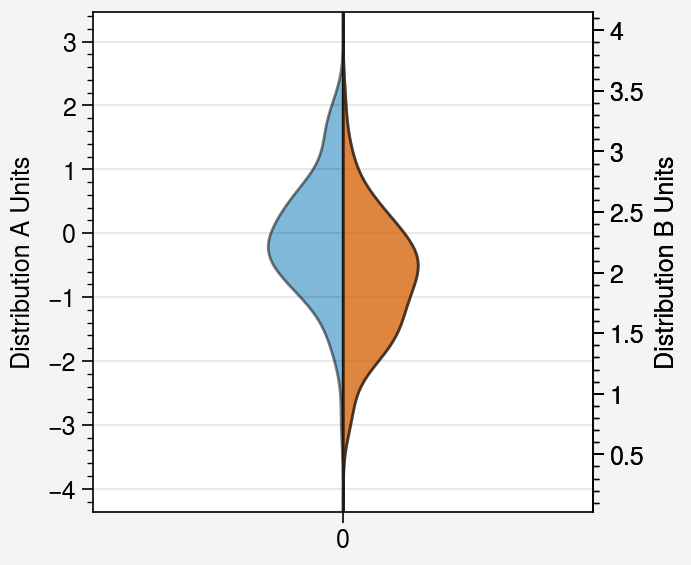

In [13]:
import proplot as pplt
import numpy as np
from statsmodels.graphics.boxplots import violinplot

# Sample data
dataA = np.random.normal(loc=0, scale=1, size=100)
dataB = np.random.normal(loc=2, scale=0.5, size=100)

# Create a figure with twin y-axes
fig, ax = pplt.subplots()
ax2 = ax.twinx()

# Plotting the violin plots
violinplot([dataA], positions=[0], show_boxplot=False, side='left', ax=ax, plot_opts={'violin_fc':'C0'})
violinplot([dataB], positions=[0], show_boxplot=False, side='right', ax=ax2, plot_opts={'violin_fc':'C1'})

# Setting axis labels
ax.set_ylabel('Distribution A Units')
ax2.set_ylabel('Distribution B Units')

# Display the plot
pplt.show()


In [18]:
plot_dict = {}

impact_category = 'climate change'

plot_data = {}
for device_type in layer_data.keys():
    device_impacts = {}
    for list_item in layer_data[device_type]:
        layer = list_item['title']
        # combinations are made up of the unique possible layer_option and location_option combinations
        device_impacts[layer] = {}
        layer_options = list_item['options'].keys()
        for layer_option in layer_options:
            
            location_options = list_item['options'][layer_option]
            for location_option in location_options:
                option_key = "-".join([layer_option, location_option, impact_category])
                device_impacts[layer][option_key] = impact_data[device_type][layer][layer_option][location_option][impact_category]

    # Extract all combinations of layer options
    layer_combinations = list(itertools.product(*[options.values() for options in device_impacts.values()]))

    # Calculate the sum of climate change impacts for each combination
    device_plot = [sum(combination) for combination in layer_combinations]
    plot_data[device_type] = device_plot

plot_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in plot_data.items() ]))

plot_dict[impact_category] = plot_df

In [ ]:
# why is cigs the most impactful